In [1]:
!nvidia-smi

Thu Oct 15 06:31:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2318/2318), done.
remote: Total 2650 (delta 512), reused 1350 (delta 299), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 25.37 MiB/s, done.
Resolving deltas: 100% (512/512), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [3]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 194kB 8.8MB/s 
     |████████████████████████████████| 14.5MB 235kB/s 
     |████████████████████████████████| 9.5MB 55.0MB/s 
     |████████████████████████████████| 460kB 50.4MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 25.9MB 117kB/s 
     |████████████████████████████████| 174kB 57.1MB/s 
     |████████████████████████████████| 3.6MB 42.3MB/s 
     |████████████████████████████████| 1.1MB 47.4MB/s 
     |████████████████████████████████| 358kB 36.3MB/s 
     |████████████████████████████████| 1.1MB 44.4MB/s 
     |████████████████████████████████| 11.6MB 47.6MB/s 
     |████████████████████████████████| 36.7MB 153kB/s 
     |████████████████████████████████| 276kB 53.0MB/s 
     |████████████████████████████████| 2.2MB 43.2MB/s 
     |████████████████████████████████| 92kB 10.7MB/s 
     |████████████████████████████████| 51kB 6.9MB/

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys 
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [5]:
print("TF Version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("Hub version:", hub.__version__)
print("GPU is","available" if tf.config.experimental.list_physical_devices("GPU")else "NOT AVAILABLE")

TF Version: 2.3.0
Eager mode: True
Hub version: 0.9.0
GPU is available


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [7]:
df.tail()

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [12]:
df.target.plot(kind='hist', title='Target distribution');

ImportError: ignored

<Figure size 432x288 with 1 Axes>

In [13]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [14]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.question_text.values, train_df.target.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text, label in train_data.take(1):
    print(text)
    print(label)



tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [15]:
label_list = [0, 1] 
max_seq_length = 128 
train_batch_size = 32


bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [16]:
def to_feature(text, label, label_list=label_list,max_seq_length = max_seq_length, tokenizer = tokenizer):
 
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  

In [17]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)



In [18]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

In [19]:
train_data.element_spec

print("####----------------------------####")

valid_data.element_spec

####----------------------------####


({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [20]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

In [21]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

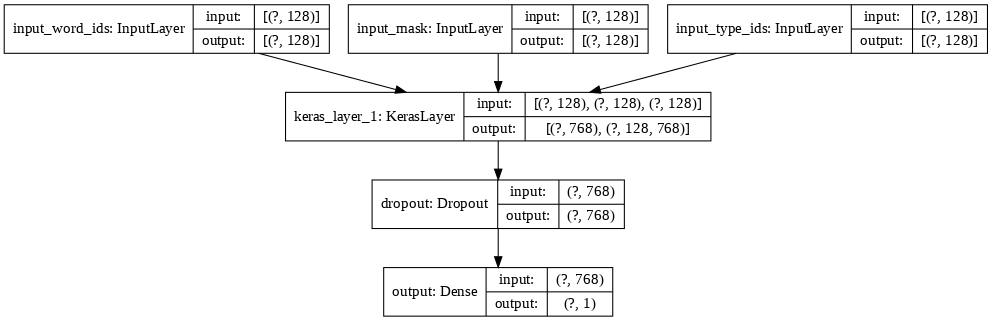

In [22]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76, )

In [ ]:
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.1749 - binary_accuracy: 0.9393WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_test_batch_end` time: 0.2625s). Check your callbacks.


306/306 [==============================] - 259s 847ms/step - loss: 0.1749 - binary_accuracy: 0.9393 - val_loss: 0.1270 - val_binary_accuracy: 0.9427
Epoch 2/4
306/306 [==============================] - 259s 845ms/step - loss: 0.1033 - binary_accuracy: 0.9615 - val_loss: 0.1283 - val_binary_accuracy: 0.9583
Epoch 3/4
306/306 [==============================] - 259s 845ms/step - loss: 0.0547 - binary_accuracy: 0.9812 - val_loss: 0.1831 - val_binary_accuracy: 0.9521
Epoch 4/4
306/306 [==============================] - 259s 846ms/step - loss: 0.0308 - binary_accuracy: 0.9901 - val_loss: 0.2202 - val_binary_accuracy: 0.9479


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
model.evaluate(valid_data, verbose=1)

In [ ]:
some_example = ["Why are unhealthy relationships so desirable?"]
test_data= tf.data.Dataset.from_tensor_slices((some_example, [0]*len(some_example)))
test_data  = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.3
['Insincere' if preds>= threshold else 'Sincere' for pred in preds]

['Sincere']